# Import

In [1]:
from quspin.basis import spin_basis_1d,photon_basis,boson_basis_1d,tensor_basis # Hilbert space bases
from quspin.operators import hamiltonian # Hamiltonian and observables
from quspin.tools.measurements import obs_vs_time,diag_ensemble # t_dep measurements
from quspin.tools.Floquet import Floquet,Floquet_t_vec # Floquet Hamiltonian
from quspin.basis.photon import coherent_state # HO coherent state
from quspin.tools.block_tools import block_diag_hamiltonian
import numpy as np # generic math functions
import matplotlib.pyplot as plt
import pylab
import scipy.sparse.linalg as sparseLA
from numpy import linalg as LA
from scipy.special import comb
import time

# Model parameters

In [2]:
N_osc=4 #number of harmonic oscillators
N_lev=3 # number of energy levels of oscillators
N_tot=N_lev**N_osc # total number of states of all photons
Omega=1.0 # frequency of the oscillator
A=0.2 # spin-photon coupling strength (drive amplitude)
Delta=0.5 # difference between atom energy levels

In [3]:
N_ph_avg=N_lev//2

In [4]:
2*N_tot

162

# Hamiltonian of a two-state atom in a reservoir of harmonic oscillators 

For the purpose of our study, we take a two-level atom (i.e. a single-site spin chain) and couple it to multiple photon mode (i.e. a quantum harmonic oscillators). The Hamiltonian reads: 
$$ H = \sum_{k=1}^{N_{osc}} \Omega_k a_k^\dagger a_k + \frac{A}{2} \frac{1}{\sqrt{N_{ph~avg}}} \sum_k (a_k^\dagger + a_k) \sigma^x + \Delta \sigma^z$$
where the operator $a^\dagger$ creates a photon in the mode, and the atom is modelled by a two-level system described by the Pauli spin operators $\sigma^{x,y,z}$. 
$N_{osc}$ is the number of harmoniv oscillators in the reservoir, $N_{lev}$ - number of energy levels of a single photon mode.
The photon frequency is $\Omega$, $N_{ph}$ is the average number of photons in a single mode, $A$ - the coupling between the EM field $E=\sum_{k=1}^{N_{osc}}\sqrt{N_{ph~avg}^{-1}}(a_k^\dagger + a_k)$, and the dipole operator $\sigma^x$, and $\Delta$ measures the energy difference between the two atomic states.

To set up the spin-photon Hamiltonian, we first build the site-coupling lists. The ph_energy list does not require the specification of a lattice site index, since the latter is not defined forthe photon sector. The at_energy list, on the other hand, requires the input of the lattice sitefor the $\sigma^z$-operator:  since we consider a single two-level system or, equivalently – a single-site chain, this index is 0. The spin-photon coupling lists absorb and emit also require the site index which refers to the corresponding Pauli matrices: in this model – 0 again due to dimensional constraints.

In [5]:
# define operator site-coupling lists
ph_energy=[[Omega,i] for i in range(N_osc)] # photon energy
at_energy=[[Delta,0]] # atom energy, 0 because the "lattice" is single-site
absorb=[[A/(2.0*np.sqrt(N_ph_avg)),0,i] for i in range(N_osc)] # absorption term
emit=[[A/(2.0*np.sqrt(N_ph_avg)),0,i] for i in range(N_osc)] # emission term

To build the static operator list, we use the $|$ symbol in the operator string to distinguish the spin and photon operators: spin operators always come to the left of the $|$-symbol,  while photon operators - to the right. For convenience, the identity operator $I$ can be omitted, suchthat $I|n$ is the same as $|n$, and $z|I$ is equivalent to $z|$, respectively. The dynamic list is empty since the spin-photon Hamiltonian is time-independent.

In [6]:
# define static and dynamics lists
static_no_interaction=[["|n",ph_energy],["z|",at_energy]]
static_rotating_wave=[["|n",ph_energy],["+|-",absorb],["-|+",emit],["z|",at_energy]]
static_full=[["|n",ph_energy],["x|-",absorb],["x|+",emit],["z|",at_energy]]
dynamic=[]

To build the spin-photon basis, we call the function photon_basis and use spin_basis_1d as the first argument. We need to specify the number of spin lattice sites, and the total numberof harmonic oscillator (a.k.a photon) states.

In [7]:
basis_osc = boson_basis_1d(L=N_osc, sps=N_lev)
#print(basis_osc)

In [8]:
# compute atom-photon basis
#basis_photon_particle=photon_basis(spin_basis_1d, L=1, Nph=L_lev)
basis_osc = boson_basis_1d(L=N_osc,sps=N_lev)
basis_spin = spin_basis_1d(L=1, pauli=-1, S='1/2')
basis = tensor_basis(basis_spin,basis_osc) 
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
	  0.         |1>           1         |2 2 2 2>           80  
	  1.         |1>           1         |2 2 2 1>           79  
	  2.         |1>           1         |2 2 2 0>           78  
	  3.         |1>           1         |2 2 1 2>           77  
	  4.         |1>           1         |2 2 1 1>           76  
	  5.         |1>           1         |2 2 1 0>           75  
	  6.         |1>           1         |2 2 0 2>           74  
	  7.         |1>           1         |2 2 0 1>           73  
	  8.         |1>           1         |2 2 0 0>           72  
	  9.         |1>           1         |2 1 2 2>           71  
	 10.         |1>           1         |2 1 2 1>           70  
	 11.         |1>           1         |2 1 2 0>           69  
	 12.         |1>           1         |2 1 1 2>           68  
	 13.         |1>           1         |2 1 1 1>           67  
	 14.         |1>           1         |2 1 1 0>  

In [9]:
# import inspect
# inspect.getmembers(tensor_basis)

In [10]:
# compute atom-photon Hamiltonian H
H_no_interaction=hamiltonian(static_no_interaction,dynamic,dtype=np.float64, basis=basis, check_symm=False, check_pcon=False, check_herm=False)
H_full=hamiltonian(static_full,dynamic,dtype=np.float64, basis=basis, check_symm=False, check_pcon=False, check_herm=False)
H_rotating_wave=hamiltonian(static_rotating_wave,dynamic,dtype=np.float64, basis=basis, check_symm=False, check_pcon=False, check_herm=False)

In [11]:
#print('Number of states of Hamiltonian:', H_rotating_wave.Ns)

# Spectrum 

In [12]:
# calculate entire spectrum only
start = time.time()
eigenvalues_H_no_interaction=H_no_interaction.eigvalsh()
end = time.time()
print('Runtime is', end-start)

Runtime is 0.00539708137512207


In [13]:
start = time.time()
eigenvalues_H_full=H_full.eigvalsh()
end = time.time()
print('Runtime is', end-start)

Runtime is 0.0070950984954833984


In [14]:
start = time.time()
eigenvalues_H_rotating_wave=H_rotating_wave.eigvalsh()
end = time.time()
print('Runtime is', end-start)

Runtime is 0.0032935142517089844


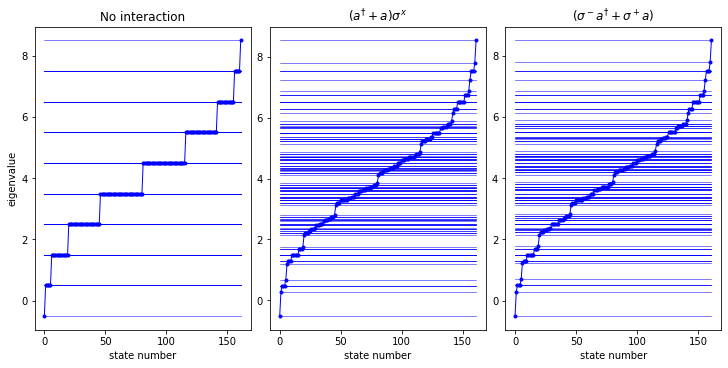

In [15]:
##### plot spectra
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True,figsize=(10,5))
x = np.arange(H_no_interaction.Ns)
ax[0].plot(x,eigenvalues_H_no_interaction, '.-', color='b', lw=1.)
ax[1].plot(x,eigenvalues_H_full, '.-', color='b', lw=1.)
ax[2].plot(x,eigenvalues_H_rotating_wave, '.-', color='b', lw=1.)
for level in x :
    ax[0].plot(x,np.full(H_no_interaction.Ns,eigenvalues_H_no_interaction[level]), '-', color='b', lw=0.5)
    ax[1].plot(x,np.full(H_full.Ns,eigenvalues_H_full[level]), '-', color='b', lw=0.5)
    ax[2].plot(x,np.full(H_rotating_wave.Ns,eigenvalues_H_rotating_wave[level]), '-', color='b', lw=0.5)
ax[0].set(title='No interaction', xlabel='state number', ylabel='eigenvalue'); ax[0].grid(False)
ax[1].set(title='$(a^\dag+a)\sigma^x$', xlabel='state number'); ax[1].grid(False)
ax[2].set(title='$(\sigma^- a^\dag+\sigma^+ a)$', xlabel='state number'); ax[1].grid(False)
plt.show()

# Definitions: blocks and eigenvalues

In [30]:
# size of of the particle-conserved basis of bosons
def boson_block_size(N_sites, N_levels, N_particles):
    Ns=0
    for r in range(N_particles//N_levels+1):
        r_2 = N_particles - r*N_levels
        if r % 2 == 0:
            Ns +=  comb(N_sites,r,exact=True) * comb(N_sites + r_2 - 1,r_2,exact=True)
        else:
            Ns += -comb(N_sites,r,exact=True) * comb(N_sites + r_2 - 1,r_2,exact=True)
    return Ns

In [36]:
def size_of_matrix_to_diagonalize_block(N_sites, N_levels, N_block):
    #return 2*boson_block_size(N_osc, N_lev, N_block)+boson_block_size(N_osc, N_lev, N_block-1)+boson_block_size(N_osc, N_lev, N_block+1)
    return boson_block_size(N_sites, N_levels, N_block-1)+boson_block_size(N_sites, N_levels, N_block)

In [39]:
size_of_matrix_to_diagonalize_block(10, 10, 10)

140988

In [40]:
def hamitonian_eigenvalues_one_block(N_block, static_list, dynamic_list) :
    basis_osc_block = boson_basis_1d(L=N_osc, Nb={N_block,N_block-1}, sps=N_lev)    # boson basis with chosen number of particles
    basis_osc_block_size = len(basis_osc_block.states)
    basis_block = tensor_basis(basis_spin,basis_osc_block)                 # mixed atom-boson basis

    basis_osc_block_n = boson_basis_1d(L=N_osc, Nb={N_block}, sps=N_lev)     # part of boson basis
    # only spin down
    selected_indices_n_down_spin = 2*basis_osc_block_size - np.searchsorted(np.flip(basis_osc_block.states), basis_osc_block_n.states) - 1   
    size_spin_down = len(selected_indices_n_down_spin)
    
    basis_osc_block_n_minus_1 = boson_basis_1d(L=N_osc, Nb={N_block-1}, sps=N_lev)     # part of boson basis
    # only spin up
    selected_indices_n_minus_1 = basis_osc_block_size - np.searchsorted(np.flip(basis_osc_block.states), basis_osc_block_n_minus_1.states) - 1  # only spin up
    size_spin_up = len(selected_indices_n_minus_1)
    
    all_selected_indices = np.concatenate((selected_indices_n_minus_1, selected_indices_n_down_spin))   # only spin down
    
    if len(all_selected_indices < 1000) :
        sparse = False
    else :
        sparse = True
    
    if sparse :
        hamiltonian_full = hamiltonian(static_list,dynamic_list,dtype=np.float64, basis=basis_block, check_symm=False, check_pcon=False, check_herm=False).tocsc()
    else :
        hamiltonian_full = hamiltonian(static_list,dynamic_list,dtype=np.float64, basis=basis_block, check_symm=False, check_pcon=False, check_herm=False).toarray()
    
    ixgrid = np.ix_(all_selected_indices, all_selected_indices)
    hamiltonian_reduced = hamiltonian_full[ixgrid]

    start = time.time()
    if sparse :
        block_eigenvals, block_eigenvectors = sparseLA.eigsh(hamiltonian_reduced,k=hamiltonian_reduced.shape[0])
    else :
        block_eigenvals, block_eigenvectors = LA.eigh(hamiltonian_reduced)   # for dense matrices
    end = time.time()
    
    print('N_photons=%2.0f, size of the reduced matrix=%2.0f, runtime=%2.6e' %(N_block, hamiltonian_reduced.shape[0], end-start))
    
    nb_of_prev_states = np.sum([size_of_matrix_to_diagonalize_block(N_osc, N_lev, n) for n in range(0,N_block)])
    states = np.arange(nb_of_prev_states, nb_of_prev_states+len(block_eigenvals))
    
    # nb_of_prev_states = np.sum([size_of_matrix_to_diagonalize_block(N_osc, N_lev, n) for n in range(0,N_block)])
    # bottom_step_begin = nb_of_prev_states - boson_block_size(N_osc, N_lev, N_block-2)
    # bottom_step_end = bottom_step_begin + size_spin_down
    # upper_step_begin = bottom_step_end + boson_block_size(N_osc, N_lev, N_block-2) + boson_block_size(N_osc, N_lev, N_block+1)
    # upper_step_end = upper_step_begin + size_spin_up
    # states = np.concatenate((np.arange(bottom_step_begin, bottom_step_end), np.arange(upper_step_begin, upper_step_end)))
    
    return states,block_eigenvals

In [41]:
hamitonian_eigenvalues_one_block(1, static_rotating_wave, dynamic)

N_photons= 1, size of the reduced matrix= 5, runtime=6.246567e-05


(array([1, 2, 3, 4, 5]), array([0.3, 0.5, 0.5, 0.5, 0.7]))

In [42]:
block_states, block_eigen_vals = hamitonian_eigenvalues_one_block(0, static_rotating_wave, dynamic)

N_photons= 0, size of the reduced matrix= 1, runtime=7.414818e-05


# Compute diagonalized blocks

In [43]:
blocks_hamiltonian_eigenvalues_no_interaction = [] 
blocks_hamiltonian_states = []
for N_block in range(0,(N_lev-1)*N_osc) : 
    states, block = hamitonian_eigenvalues_one_block(N_block, static_no_interaction, dynamic)
    blocks_hamiltonian_states.append(states)
    blocks_hamiltonian_eigenvalues_no_interaction.append(block)

N_photons= 0, size of the reduced matrix= 1, runtime=4.792213e-05
N_photons= 1, size of the reduced matrix= 5, runtime=6.413460e-05
N_photons= 2, size of the reduced matrix=14, runtime=6.699562e-05
N_photons= 3, size of the reduced matrix=26, runtime=6.580353e-05
N_photons= 4, size of the reduced matrix=35, runtime=2.255678e-03
N_photons= 5, size of the reduced matrix=35, runtime=1.857281e-04
N_photons= 6, size of the reduced matrix=26, runtime=3.623962e-05
N_photons= 7, size of the reduced matrix=14, runtime=3.576279e-05


In [44]:
blocks_hamiltonian_eigenvalues_rotating_wave = [] 
for N_block in range(0,(N_lev-1)*N_osc) : 
    states, block = hamitonian_eigenvalues_one_block(N_block, static_rotating_wave, dynamic)
    blocks_hamiltonian_eigenvalues_rotating_wave.append(block)

N_photons= 0, size of the reduced matrix= 1, runtime=9.465218e-05
N_photons= 1, size of the reduced matrix= 5, runtime=7.009506e-05
N_photons= 2, size of the reduced matrix=14, runtime=1.969337e-04
N_photons= 3, size of the reduced matrix=26, runtime=1.745701e-03
N_photons= 4, size of the reduced matrix=35, runtime=4.005909e-03
N_photons= 5, size of the reduced matrix=35, runtime=6.971359e-04
N_photons= 6, size of the reduced matrix=26, runtime=1.554012e-03
N_photons= 7, size of the reduced matrix=14, runtime=2.007484e-04


# Check

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
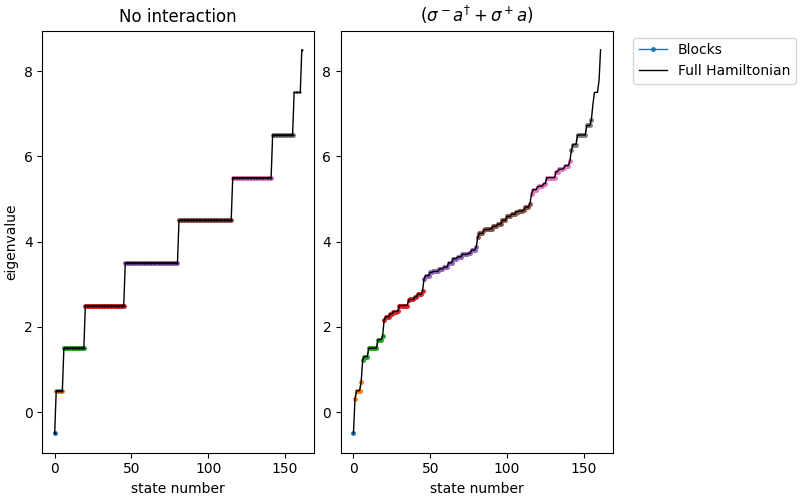

In [45]:
%matplotlib widget
##### plot spectra
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(8,5))

# no interation
for i,block in enumerate(blocks_hamiltonian_eigenvalues_no_interaction) :
    ax[0].plot(blocks_hamiltonian_states[i], block, '.-', lw=1., ms=5.0)
ax[0].plot(np.arange(H_no_interaction.Ns),eigenvalues_H_no_interaction, '.-', color='k', lw=1., ms=1.0)
ax[0].set(title='No interaction', xlabel='state number', ylabel='eigenvalue'); ax[0].grid(False)

#rotating wave approx
for i, block in enumerate(blocks_hamiltonian_eigenvalues_rotating_wave) :
    ax[1].plot(blocks_hamiltonian_states[i], block, '.-', lw=1., ms=5.0, label=('Blocks' if i==0 else ''))
ax[1].plot(eigenvalues_H_rotating_wave, '-', color='k', lw=1., ms=1.0, label='Full Hamiltonian')
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1].set(title='$(\sigma^- a^\dag+\sigma^+ a)$', xlabel='state number'); ax[1].grid(False)
plt.show()

In [50]:
# fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(4.5,3.5))
# for i, block in enumerate(blocks_hamiltonian_eigenvalues_rotating_wave) :
#     x = np.array(blocks_hamiltonian_states[i], dtype=int)
#     ax.plot(x, block-eigenvalues_H_rotating_wave[x], '.-')
# ax.set(title='Error', xlabel='state number')
# plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
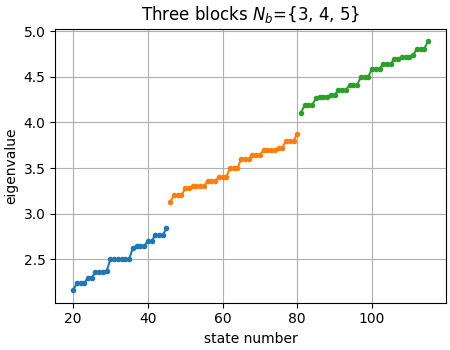

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(4.5,3.5))
N_block={3,4,5}
for block in N_block :  
    ax.plot(blocks_hamiltonian_states[block], blocks_hamiltonian_eigenvalues_rotating_wave[block], '.-')
ax.set(title=r'Three blocks $N_b$=' + str(N_block), xlabel='state number', ylabel='eigenvalue'); ax.grid()
plt.show()